# hockey.py

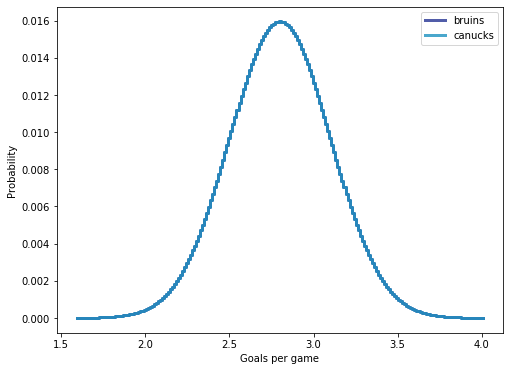

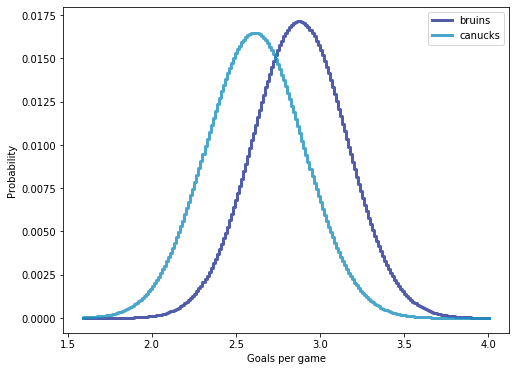

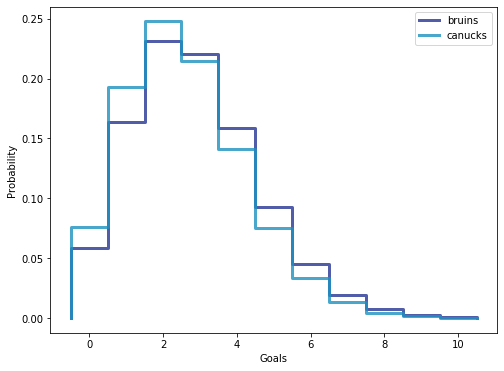

MLE bruins 2.872
MLE canucks 2.608


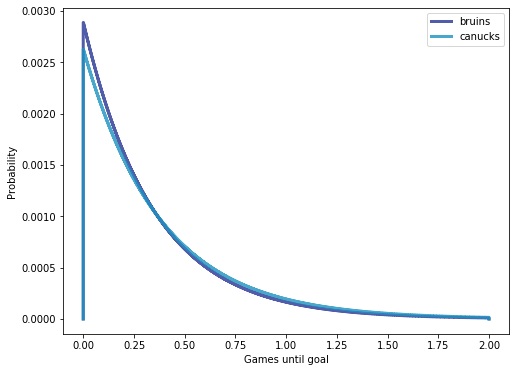

0.45799649207235477 0.3702934089545197 0.171710098973125
p_overtime 0.5234712217950667
0.08988529530401357
p_win 0.5478817873763684
p_series 0.571603127214589


<Figure size 576x432 with 0 Axes>

In [2]:
"""This file contains code for use with "Think Bayes",
by Allen B. Downey, available from greenteapress.com

Copyright 2012 Allen B. Downey
License: GNU GPLv3 http://www.gnu.org/licenses/gpl.html
"""
from __future__ import print_function

import sys
sys.path.append("../code/")

import math

import columns
import thinkbayes
import thinkstats
import thinkplot


USE_SUMMARY_DATA = True

file_path="../code/"

class Hockey(thinkbayes.Suite):
    """Represents hypotheses about the scoring rate for a team."""

    def __init__(self, name=''):
        """Initializes the Hockey object.

        name: string
        """
        if USE_SUMMARY_DATA:
            # prior based on each team's average goals scored
            mu = 2.8
            sigma = 0.3
        else:
            # prior based on each pair-wise match-up
            mu = 2.8
            sigma = 0.85

        pmf = thinkbayes.MakeGaussianPmf(mu, sigma, 4)
        thinkbayes.Suite.__init__(self, pmf, name=name)
            
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        Evaluates the Poisson PMF for lambda and k.

        hypo: goal scoring rate in goals per game
        data: goals scored in one period
        """
        lam = hypo
        k = data
        like = thinkbayes.EvalPoissonPmf(k, lam)
        return like


def MakeGoalPmf(suite, high=10):
    """Makes the distribution of goals scored, given distribution of lam.

    suite: distribution of goal-scoring rate
    high: upper bound

    returns: Pmf of goals per game
    """
    metapmf = thinkbayes.Pmf()

    for lam, prob in suite.Items():
        pmf = thinkbayes.MakePoissonPmf(lam, high)
        metapmf.Set(pmf, prob)

    mix = thinkbayes.MakeMixture(metapmf, name=suite.name)
    return mix


def MakeGoalTimePmf(suite):
    """Makes the distribution of time til first goal.

    suite: distribution of goal-scoring rate

    returns: Pmf of goals per game
    """
    metapmf = thinkbayes.Pmf()

    for lam, prob in suite.Items():
        pmf = thinkbayes.MakeExponentialPmf(lam, high=2, n=2001)
        metapmf.Set(pmf, prob)

    mix = thinkbayes.MakeMixture(metapmf, name=suite.name)
    return mix


class Game(object):
    """Represents a game.

    Attributes are set in columns.read_csv.
    """
    convert = dict()

    def clean(self):
        self.goals = self.pd1 + self.pd2 + self.pd3


def ReadHockeyData(filename=file_path+'hockey_data.csv'):
    """Read game scores from the data file.

    filename: string
    """
    game_list = columns.read_csv(filename, Game)

    # map from gameID to list of two games
    games = {}
    for game in game_list:
        if game.season != 2011:
            continue
        key = game.game
        games.setdefault(key, []).append(game)

    # map from (team1, team2) to (score1, score2)
    pairs = {}
    for key, pair in games.items():
        t1, t2 = pair
        key = t1.team, t2.team
        entry = t1.total, t2.total
        pairs.setdefault(key, []).append(entry)

    ProcessScoresTeamwise(pairs)
    ProcessScoresPairwise(pairs)


def ProcessScoresPairwise(pairs):
    """Average number of goals for each team against each opponent.

    pairs: map from (team1, team2) to (score1, score2)
    """
    # map from (team1, team2) to list of goals scored
    goals_scored = {}
    for key, entries in pairs.items():
        t1, t2 = key
        for entry in entries:
            g1, g2 = entry
            goals_scored.setdefault((t1, t2), []).append(g1)
            goals_scored.setdefault((t2, t1), []).append(g2)

    # make a list of average goals scored
    lams = []
    for key, goals in goals_scored.items():
        if len(goals) < 3:
            continue
        lam = thinkstats.Mean(goals)
        lams.append(lam)

    # make the distribution of average goals scored
    cdf = thinkbayes.MakeCdfFromList(lams)
    thinkplot.Cdf(cdf)
    thinkplot.Show()

    mu, var = thinkstats.MeanVar(lams)
    print('mu, sig', mu, math.sqrt(var))

    print('BOS v VAN', pairs['BOS', 'VAN'])


def ProcessScoresTeamwise(pairs):
    """Average number of goals for each team.

    pairs: map from (team1, team2) to (score1, score2)
    """
    # map from team to list of goals scored
    goals_scored = {}
    for key, entries in pairs.items():
        t1, t2 = key
        for entry in entries:
            g1, g2 = entry
            goals_scored.setdefault(t1, []).append(g1)
            goals_scored.setdefault(t2, []).append(g2)

    # make a list of average goals scored
    lams = []
    for key, goals in goals_scored.items():
        lam = thinkstats.Mean(goals)
        lams.append(lam)

    # make the distribution of average goals scored
    cdf = thinkbayes.MakeCdfFromList(lams)
    thinkplot.Cdf(cdf)
    thinkplot.Show()

    mu, var = thinkstats.MeanVar(lams)
    print('mu, sig', mu, math.sqrt(var))


def main():
    #ReadHockeyData()
    #return

    formats = ['pdf', 'eps']

    suite1 = Hockey('bruins')
    suite2 = Hockey('canucks')

    thinkplot.Clf()
    thinkplot.PrePlot(num=2)
    thinkplot.Pmf(suite1)
    thinkplot.Pmf(suite2)
    thinkplot.Show(xlabel='Goals per game',
                   ylabel='Probability')
#     thinkplot.Save(root='hockey0',
#                 xlabel='Goals per game',
#                 ylabel='Probability',
#                 formats=formats)

    suite1.UpdateSet([0, 2, 8, 4])
    suite2.UpdateSet([1, 3, 1, 0])

    thinkplot.Clf()
    thinkplot.PrePlot(num=2)
    thinkplot.Pmf(suite1)
    thinkplot.Pmf(suite2)
    thinkplot.Show(xlabel='Goals per game',
                ylabel='Probability')
#     thinkplot.Save(root='hockey1',
#                 xlabel='Goals per game',
#                 ylabel='Probability',
#                 formats=formats)


    goal_dist1 = MakeGoalPmf(suite1)
    goal_dist2 = MakeGoalPmf(suite2)

    thinkplot.Clf()
    thinkplot.PrePlot(num=2)
    thinkplot.Pmf(goal_dist1)
    thinkplot.Pmf(goal_dist2)
    thinkplot.Show(xlabel='Goals',
                ylabel='Probability')
#     thinkplot.Save(root='hockey2',
#                 xlabel='Goals',
#                 ylabel='Probability',
#                 formats=formats)

    time_dist1 = MakeGoalTimePmf(suite1)    
    time_dist2 = MakeGoalTimePmf(suite2)
 
    print('MLE bruins', suite1.MaximumLikelihood())
    print('MLE canucks', suite2.MaximumLikelihood())
   
    thinkplot.Clf()
    thinkplot.PrePlot(num=2)
    thinkplot.Pmf(time_dist1)
    thinkplot.Pmf(time_dist2)
    thinkplot.Show(xlabel='Games until goal',
                   ylabel='Probability')
#     thinkplot.Save(root='hockey3',
#                    xlabel='Games until goal',
#                    ylabel='Probability',
#                    formats=formats)

    diff = goal_dist1 - goal_dist2
    p_win = diff.ProbGreater(0)
    p_loss = diff.ProbLess(0)
    p_tie = diff.Prob(0)

    print(p_win, p_loss, p_tie)

    p_overtime = thinkbayes.PmfProbLess(time_dist1, time_dist2)
    p_adjust = thinkbayes.PmfProbEqual(time_dist1, time_dist2)
    p_overtime += p_adjust / 2
    print('p_overtime', p_overtime)

    print(p_overtime * p_tie)
    p_win += p_overtime * p_tie
    print('p_win', p_win)

    # win the next two
    p_series = p_win**2

    # split the next two, win the third
    p_series += 2 * p_win * (1-p_win) * p_win

    print('p_series', p_series)


if __name__ == '__main__':
    main()


# rewrite

In [20]:
import math

import sys
sys.path.append("../code/")

import thinkbayes
import thinkstats
import thinkplot

file_path="../code/"

class Hockey(thinkbayes.Suite):
    def __init__(self,name=""):
        # mu and sigma are from history data, n is the num of hupothesis point
        pmf=thinkbayes.MakeGaussianPmf(mu=2.8,sigma=0.3,num_sigmas=4,n=501)
        thinkbayes.Suite.__init__(self,pmf,name=name)
    
    def Likelihood(self,hypo,data):
        lam=hypo
        k=data
        like=thinkbayes.EvalPoissonPmf(lam,k)
        # like=(lam)**k * math.exp(-lam) / math.factorial(k)
        return like

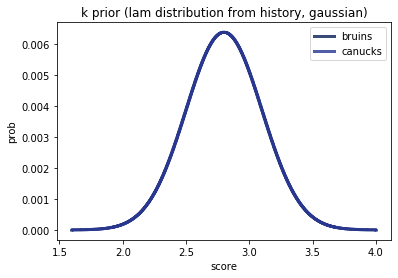

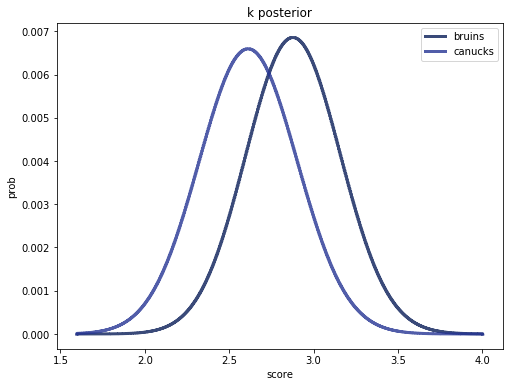

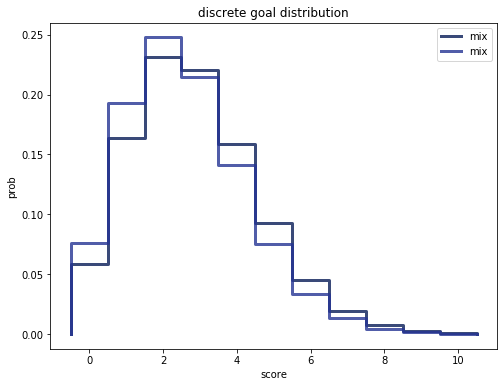

<Figure size 576x432 with 0 Axes>

In [28]:
# continuous score distribution
suite1=Hockey("bruins")
suite2=Hockey("canucks")

thinkplot.Pmfs([suite1,suite2])
thinkplot.Show(xlabel="score",ylabel="prob",title="k prior (lam distribution from history, gaussian)")

suite1.UpdateSet([0,2,8,4])  # data from this game
suite2.UpdateSet([1,3,1,0])

thinkplot.Pmfs([suite1,suite2])
thinkplot.Show(xlabel="score",ylabel="prob",title="k posterior")

# distribution for discrete score

# make mixture distribution (weighted by discrete lam prob -> given by suite)
def MakeGoalPmf(suite):
    metapmf=thinkbayes.Pmf()
    for lam, prob in suite.Items():
        # get distribution for discrete score, with given lam
        goal_dist=thinkbayes.MakePoissonPmf(lam,high=10)  # cut the distribution at score=high
        metapmf.Set(goal_dist,prob)
    mix=thinkbayes.MakeMixture(metapmf)  # make mixture distribution by each distribution and prob
    return mix

# Add weight (from suite)
goal_dist1=MakeGoalPmf(suite1)
goal_dist2=MakeGoalPmf(suite2)

thinkplot.Pmfs([goal_dist1,goal_dist2])
thinkplot.Show(xlabel="score",ylabel="prob",title="discrete goal distribution")


In [38]:
# win probability
diff=goal_dist1-goal_dist2  # Pmf object
p_win=diff.ProbGreater(0)
p_loss=diff.ProbLess(0)
p_tie=diff.Prob(0)
print("Bruins win: {}, loss: {}, tie: {}".format(round(p_win,3),round(p_loss,3),round(p_tie,3)))

Bruins win: 0.458, loss: 0.37, tie: 0.172


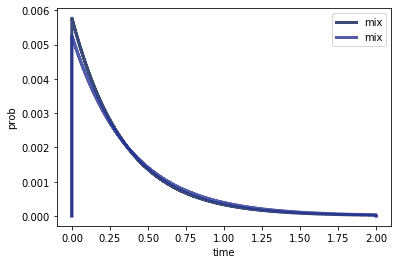

Bruins win at overtime: 0.522
Bruins win total: 0.548


<Figure size 576x432 with 0 Axes>

In [47]:
# sudden-death in extra time
# the team who get the first goal wins

# the time to get the first goal is Poisson distribution
# time is the number of games

# make mixture distribution (weighted by discrete lam prob -> given by suite)
def MakeGoalTimePmf(suite):
    metapmf=thinkbayes.Pmf()
    for lam, prob in suite.Items():
        # get distribution for discrete score, with given lam
        time_dist=thinkbayes.MakeExponentialPmf(lam,high=2,n=1001)  # cut the distribution at time=2
        metapmf.Set(time_dist,prob)
    mix=thinkbayes.MakeMixture(metapmf)  # make mixture distribution by each distribution and prob
    return mix

time_dist1=MakeGoalTimePmf(suite1)
time_dist2=MakeGoalTimePmf(suite2)

thinkplot.Pmfs([time_dist1,time_dist2])
thinkplot.Show(xlabel="time",ylabel="prob")

p_win_overtime=thinkbayes.PmfProbLess(time_dist1,time_dist2)
print("Bruins win at overtime: {}".format(round(p_win_overtime,3)))

p_win_total=p_win+p_tie*p_win_overtime
print("Bruins win total: {}".format(round(p_win_total,3)))
